In [1]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import xgboost as xgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go

data_path: str = "../data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")

cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type": "_type",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_index": "coinbase_premium_index",
    "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd": "long_liquidations_usd",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd": "short_liquidations_usd",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "buy_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "buy_sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
    "hourly_network-data_addresses-count_addresses_count_active": "active_count",
    "hourly_network-data_addresses-count_addresses_count_receiver": "receiver_count",
    "hourly_network-data_addresses-count_addresses_count_sender": "sender_count",
}

df = df[cols_dict.keys()].rename(cols_dict, axis=1)

# eda 에서 파악한 차이와 차이의 음수, 양수 여부를 새로운 피쳐로 생성
# eda 에서 파악한 차이와 차이의 음수, 양수 여부를 새로운 피쳐로 생성
df = df.assign(
    liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
    liquidation_usd_diff=df["long_liquidations_usd"] - df["short_liquidations_usd"],
    volume_diff=df["buy_volume"] - df["sell_volume"],
    liquidation_diffg=np.sign(df["long_liquidations"] - df["short_liquidations"]),
    liquidation_usd_diffg=np.sign(df["long_liquidations_usd"] - df["short_liquidations_usd"]),
    volume_diffg=np.sign(df["buy_volume"] - df["sell_volume"]),
    buy_sell_volume_ratio=df["buy_volume"] / (df["sell_volume"] + 1),
)

df['buy_volume_ma_3h'] = df['buy_volume'].rolling(window=3).mean()
df['buy_volume_std_3h'] = df['buy_volume'].rolling(window=3).std()

df['funding_rates_ma_3h'] = df['funding_rates'].rolling(window=3).mean()
df['funding_rates_std_3h'] = df['funding_rates'].rolling(window=3).std()

df['price_close_pct_change_1h'] = 100*(df['coinbase_premium_gap']-df['coinbase_premium_gap'].shift(1))/(df['coinbase_premium_gap'].shift(1)+100)
df['price_close_pct_change_3h'] = 100*(df['coinbase_premium_gap']-df['coinbase_premium_gap'].shift(3))/(df['coinbase_premium_gap'].shift(3)+100)

df['buy_volume_pct_change_1h'] = 100*(df['buy_volume']-df['buy_volume'].shift(1))/(df['buy_volume'].shift(1)+1)
df['buy_volume_pct_change_3h'] = 100*(df['buy_volume']-df['buy_volume'].shift(3))/(df['buy_volume'].shift(3)+1)

df['liquidation_diff_pct_change_3h'] = 100*(df['liquidation_diff']-df['liquidation_diff'].shift(3))/(df['liquidation_diff'].shift(3)+1)

# df['buy_sell_ratio_pct_change_3h'] = df['buy_sell_ratio'].pct_change(periods=3)
# df['is_buy_dominant'] = (df['buy_sell_ratio'] > 1.0).astype(int)


df['interaction_buy_funding'] = df['buy_volume'] * df['funding_rates']
df['interaction_liquidation_volume'] = df['liquidation_diff'] / (df['volume_diff'] + 1)

# df['buy_volume_cumsum'] = df['buy_volume'].cumsum()
# df['liquidation_diff_cumsum'] = df['liquidation_diff'].cumsum()


# df['time_since_buy_peak'] = (df['buy_volume'] > df['buy_volume'].quantile(0.95)).astype(int).cumsum()

# df['buy_volume_squared'] = df['buy_volume'] ** 2
# df['funding_rates_cubed'] = df['funding_rates'] ** 3

# category, continuous 열을 따로 할당해둠
category_cols: List[str] = ["liquidation_diffg", "liquidation_usd_diffg", "volume_diffg"]
conti_cols: List[str] = [_ for _ in cols_dict.values() if _ not in ["ID", "target", "_type"]] + [
    "buy_sell_volume_ratio", "liquidation_diff", "liquidation_usd_diff", "volume_diff",
    "buy_volume_ma_3h", "buy_volume_std_3h", "funding_rates_ma_3h", "funding_rates_std_3h",
    "price_close_pct_change_1h", "price_close_pct_change_3h", "buy_volume_pct_change_1h", "buy_volume_pct_change_3h",
    "liquidation_diff_pct_change_3h", # "buy_sell_ratio_pct_change_3h", "is_buy_dominant",
    'interaction_buy_funding', 'interaction_liquidation_volume',
    # 'buy_volume_cumsum', 'liquidation_diff_cumsum', 
    # # 'buy_volume_squared', 'funding_rates_cubed', 
    # # 'time_since_buy_peak'
]

def shift_feature(
    df: pd.DataFrame,
    conti_cols: List[str],
    intervals: List[int],
) -> List[pd.Series]:
    df_shift_dict = [
        df[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
        for conti_col in conti_cols
        for interval in intervals
    ]
    return df_shift_dict

shift_list = shift_feature(
    df=df, conti_cols=conti_cols, intervals=[_ for _ in range(1, 24)]
)
df = pd.concat([df, pd.concat(shift_list, axis=1)], axis=1)

_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)

train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

def window_slicing(df: pd.DataFrame, window_size: int, step_size: int) -> pd.DataFrame:
    sliced_data = []
    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size
        window_df = df.iloc[start:end].copy()
        sliced_data.append(window_df)
    sliced_data_df = pd.concat(sliced_data, axis=0).reset_index(drop=True)
    return sliced_data_df

window_size = 24
step_size = 12

train_0_3 = train_df[train_df['target'].isin([0, 3])]
train_1_2 = train_df[~train_df['target'].isin([0, 3])]

augm_0_3 = window_slicing(train_0_3, window_size=window_size, step_size=step_size)

def noise_injection(df: pd.DataFrame, noise_level: float = 0.01, decay: float = 0.99) -> pd.DataFrame:
    df_noisy = df.copy()
    time_steps = np.arange(len(df_noisy))
    for col in df_noisy.select_dtypes(include=[np.number]).columns:
        noise = np.random.normal(0, noise_level*df_noisy[col].std(), size=df_noisy[col].shape)
        decays = decay ** time_steps
        df_noisy[col] = df_noisy[col] + noise * decays
    return df_noisy    

train03 = train_df[train_df['target'].isin([0, 3])]

df_noisy = noise_injection(augm_0_3.drop(columns=['target', 'ID']))
df_noisy = df_noisy.reset_index(drop=True)
augm03 = augm_0_3.reset_index(drop=True) 
df_noisy['target'] = augm03['target'].values
df_noisy['ID'] = augm03['ID'].values

train_df_augm = pd.concat([train_1_2, df_noisy], axis=0)

x_train, x_valid, y_train, y_valid = train_test_split(
    train_df_augm.drop(["target", "ID"], axis=1), 
    train_df_augm["target"].astype(int), 
    test_size=0.2,
    random_state=42,
)

params = {
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "num_class": 4,
    "learning_rate": 0.05,
    "max_depth": 6,
    "random_state": 42,
}


# DMatrix로 변환
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(test_df.drop(["target", "ID"], axis=1))

# 모델 학습
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=30,
)

# 예측
y_test_pred_1 = xgb_model.predict(dtest)
y_test_pred_class_1 = np.argmax(y_test_pred_1, axis=1)

100%|██████████| 107/107 [00:01<00:00, 58.97it/s]


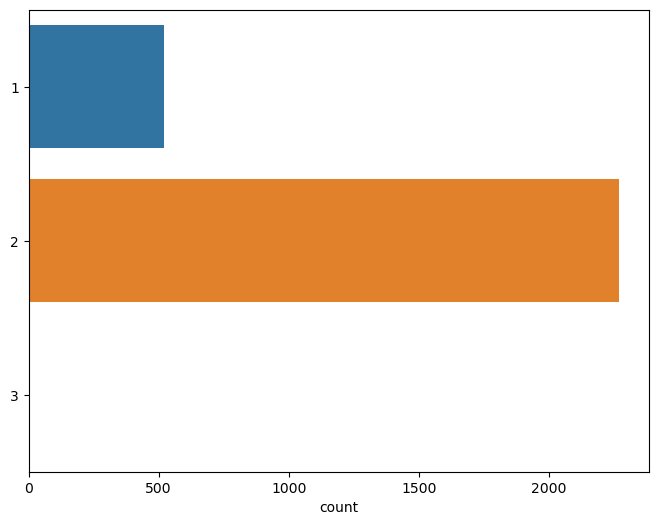

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.countplot(y=y_test_pred_class_1, order=np.unique(y_test_pred_class_1))
plt.show()

In [3]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
data_path: str = "../data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type": "_type",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_index": "coinbase_premium_index",
    "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd": "long_liquidations_usd",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd": "short_liquidations_usd",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "buy_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "buy_sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
    "hourly_network-data_addresses-count_addresses_count_active": "active_count",
    "hourly_network-data_addresses-count_addresses_count_receiver": "receiver_count",
    "hourly_network-data_addresses-count_addresses_count_sender": "sender_count",
}
df = df[cols_dict.keys()].rename(cols_dict, axis=1)
df = df.assign(
    liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
    liquidation_usd_diff=df["long_liquidations_usd"] - df["short_liquidations_usd"],
    volume_diff=df["buy_volume"] - df["sell_volume"],
    liquidation_diffg=np.sign(df["long_liquidations"] - df["short_liquidations"]),
    liquidation_usd_diffg=np.sign(df["long_liquidations_usd"] - df["short_liquidations_usd"]),
    volume_diffg=np.sign(df["buy_volume"] - df["sell_volume"]),
    buy_sell_volume_ratio=df["buy_volume"] / (df["sell_volume"] + 1),
)

df['buy_volume_ma_3h'] = df['buy_volume'].rolling(window=3).mean()
df['buy_volume_std_3h'] = df['buy_volume'].rolling(window=3).std()

df['funding_rates_ma_3h'] = df['funding_rates'].rolling(window=3).mean()
df['funding_rates_std_3h'] = df['funding_rates'].rolling(window=3).std()

df['price_close_pct_change_1h'] = df['coinbase_premium_gap'].pct_change(periods=1)
df['price_close_pct_change_3h'] = df['coinbase_premium_gap'].pct_change(periods=3)

df['buy_volume_pct_change_1h'] = df['buy_volume'].pct_change(periods=1)
df['buy_volume_pct_change_3h'] = df['buy_volume'].pct_change(periods=3)

df['liquidation_diff_pct_change_3h'] = df['liquidation_diff'].pct_change(periods=3)

df['buy_sell_ratio_pct_change_3h'] = df['buy_sell_ratio'].pct_change(periods=3)
df['is_buy_dominant'] = (df['buy_sell_ratio'] > 1.0).astype(int)


# category, continuous 열을 따로 할당해둠
category_cols: List[str] = ["liquidation_diffg", "liquidation_usd_diffg", "volume_diffg"]
conti_cols: List[str] = [_ for _ in cols_dict.values() if _ not in ["ID", "target", "_type"]] + [
    "buy_sell_volume_ratio", "liquidation_diff", "liquidation_usd_diff", "volume_diff",
    "buy_volume_ma_3h", "buy_volume_std_3h", "funding_rates_ma_3h", "funding_rates_std_3h",
    "price_close_pct_change_1h", "price_close_pct_change_3h", "buy_volume_pct_change_1h", "buy_volume_pct_change_3h",
    "liquidation_diff_pct_change_3h", "buy_sell_ratio_pct_change_3h", "is_buy_dominant",
]
def shift_feature(
    df: pd.DataFrame,
    conti_cols: List[str],
    intervals: List[int],
) -> List[pd.Series]:
    """
    연속형 변수의 shift feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        intervals (List[int]): shifted intervals
    Return:
        List[pd.Series]
    """
    df_shift_dict = [
        df[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
        for conti_col in conti_cols
        for interval in intervals
    ]
    return df_shift_dict

# 최대 24시간의 shift 피쳐를 계산
shift_list = shift_feature(
    df=df, conti_cols=conti_cols, intervals=[_ for _ in range(1, 24)]
)
# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)

# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])
def window_slicing(df: pd.DataFrame, window_size: int, step_size: int) -> pd.DataFrame:
    sliced_data = []
    
    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size
        window_df = df.iloc[start:end].copy()
        # window_df['window_start_index'] = start
        sliced_data.append(window_df)
    
    sliced_data_df = pd.concat(sliced_data, axis=0).reset_index(drop=True)
    return sliced_data_df

window_size = 24
step_size = 12

train_0_3 = train_df[train_df['target'].isin([0, 3])]
train_1_2 = train_df[~train_df['target'].isin([0, 3])]

augm_0_3 = window_slicing(train_0_3, window_size=window_size, step_size=step_size)
def noise_injection(df: pd.DataFrame, noise_level: float = 0.01, decay: float = 0.99) -> pd.DataFrame:
    df_noisy = df.copy()
    time_steps = np.arange(len(df_noisy))
    for col in df_noisy.select_dtypes(include=[np.number]).columns:
        noise = np.random.normal(0, noise_level*df_noisy[col].std(), size=df_noisy[col].shape)
        decays = decay ** time_steps
        df_noisy[col] = df_noisy[col] + noise * decays
    
    return df_noisy    

train03 = train_df[train_df['target'].isin([0, 3])]

df_noisy = noise_injection(augm_0_3.drop(columns=['target', 'ID']))
df_noisy = df_noisy.reset_index(drop=True)
augm03 = augm_0_3.reset_index(drop=True) 
df_noisy['target'] = augm03['target'].values
df_noisy['ID'] = augm03['ID'].values

train_df_augm = pd.concat([train_1_2, df_noisy], axis=0)
x_train, x_valid, y_train, y_valid = train_test_split(
    train_df_augm.drop(["target", "ID"], axis = 1), 
    train_df_augm["target"].astype(int), 
    test_size=0.2,
    random_state=42,
)

# params
params = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 4,
    "num_leaves": 50,
    "learning_rate": 0.05,
    "n_estimators": 30,
    "random_state": 42,
    "verbose": 0,
}

x_train = train_df_augm.drop(["target", "ID"], axis = 1)
y_train = train_df_augm["target"].astype(int)
train_data = lgb.Dataset(x_train, label=y_train)
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
)

y_test_pred_2 = lgb_model.predict(test_df.drop(["target", "ID"], axis = 1))
y_test_pred_class_2 = np.argmax(y_test_pred_2, axis = 1)


100%|██████████| 107/107 [00:03<00:00, 33.84it/s]
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002213 seconds.
You can set `force_col_wise=true` to remove the overhead.


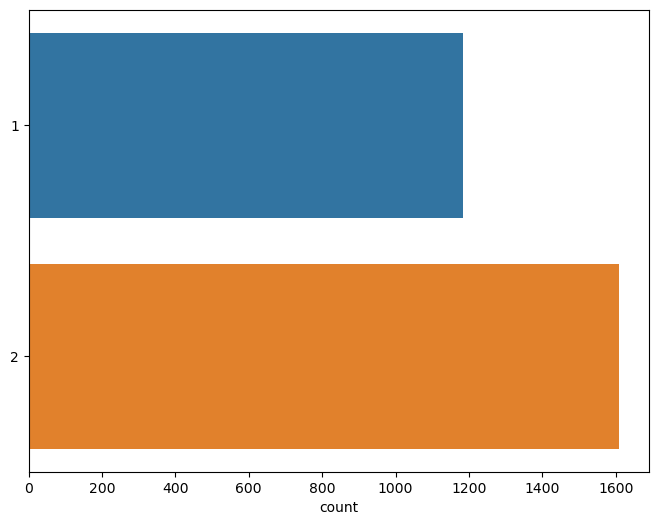

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.countplot(y=y_test_pred_class_2, order=np.unique(y_test_pred_class_2))
plt.show()

In [5]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
data_path: str = "../data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type": "_type",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_index": "coinbase_premium_index",
    "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd": "long_liquidations_usd",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd": "short_liquidations_usd",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "buy_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "buy_sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
    "hourly_network-data_addresses-count_addresses_count_active": "active_count",
    "hourly_network-data_addresses-count_addresses_count_receiver": "receiver_count",
    "hourly_network-data_addresses-count_addresses_count_sender": "sender_count",
}
df = df[cols_dict.keys()].rename(cols_dict, axis=1)
df = df.assign(
    liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
    liquidation_usd_diff=df["long_liquidations_usd"] - df["short_liquidations_usd"],
    volume_diff=df["buy_volume"] - df["sell_volume"],
    liquidation_diffg=np.sign(df["long_liquidations"] - df["short_liquidations"]),
    liquidation_usd_diffg=np.sign(df["long_liquidations_usd"] - df["short_liquidations_usd"]),
    volume_diffg=np.sign(df["buy_volume"] - df["sell_volume"]),
    buy_sell_volume_ratio=df["buy_volume"] / (df["sell_volume"] + 1),
)

df['buy_volume_ma_3h'] = df['buy_volume'].rolling(window=3).mean()
df['buy_volume_std_3h'] = df['buy_volume'].rolling(window=3).std()

df['funding_rates_ma_3h'] = df['funding_rates'].rolling(window=3).mean()
df['funding_rates_std_3h'] = df['funding_rates'].rolling(window=3).std()

df['price_close_pct_change_1h'] = df['coinbase_premium_gap'].pct_change(periods=1)
df['price_close_pct_change_3h'] = df['coinbase_premium_gap'].pct_change(periods=3)

df['buy_volume_pct_change_1h'] = df['buy_volume'].pct_change(periods=1)
df['buy_volume_pct_change_3h'] = df['buy_volume'].pct_change(periods=3)

df['liquidation_diff_pct_change_3h'] = df['liquidation_diff'].pct_change(periods=3)

df['buy_sell_ratio_pct_change_3h'] = df['buy_sell_ratio'].pct_change(periods=3)
df['is_buy_dominant'] = (df['buy_sell_ratio'] > 1.0).astype(int)


df['interaction_buy_funding'] = df['buy_volume'] * df['funding_rates']
df['interaction_liquidation_volume'] = df['liquidation_diff'] / (df['volume_diff'] + 1)

df['buy_volume_cumsum'] = df['buy_volume'].cumsum()
df['liquidation_diff_cumsum'] = df['liquidation_diff'].cumsum()


df['time_since_buy_peak'] = (df['buy_volume'] > df['buy_volume'].quantile(0.95)).astype(int).cumsum()

df['buy_volume_squared'] = df['buy_volume'] ** 2
df['funding_rates_cubed'] = df['funding_rates'] ** 3

category_cols: List[str] = ["liquidation_diffg", "liquidation_usd_diffg", "volume_diffg"]
conti_cols: List[str] = [_ for _ in cols_dict.values() if _ not in ["ID", "target", "_type"]] + [
    "buy_sell_volume_ratio", "liquidation_diff", "liquidation_usd_diff", "volume_diff",
    "buy_volume_ma_3h", "buy_volume_std_3h", "funding_rates_ma_3h", "funding_rates_std_3h",
    "price_close_pct_change_1h", "price_close_pct_change_3h", "buy_volume_pct_change_1h", "buy_volume_pct_change_3h",
    "liquidation_diff_pct_change_3h", "buy_sell_ratio_pct_change_3h", "is_buy_dominant",
    'interaction_buy_funding', 'interaction_liquidation_volume',
    'buy_volume_cumsum', 'liquidation_diff_cumsum', 
    'buy_volume_squared', 'funding_rates_cubed', 
    'time_since_buy_peak'
]
def shift_feature(
    df: pd.DataFrame,
    conti_cols: List[str],
    intervals: List[int],
) -> List[pd.Series]:
    """
    연속형 변수의 shift feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        intervals (List[int]): shifted intervals
    Return:
        List[pd.Series]
    """
    df_shift_dict = [
        df[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
        for conti_col in conti_cols
        for interval in intervals
    ]
    return df_shift_dict

shift_list = shift_feature(
    df=df, conti_cols=conti_cols, intervals=[_ for _ in range(1, 24)]
)
_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)

# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])
def window_slicing(df: pd.DataFrame, window_size: int, step_size: int) -> pd.DataFrame:
    sliced_data = []
    
    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size
        window_df = df.iloc[start:end].copy()
        # window_df['window_start_index'] = start
        sliced_data.append(window_df)
    
    sliced_data_df = pd.concat(sliced_data, axis=0).reset_index(drop=True)
    return sliced_data_df

window_size = 24
step_size = 12

train_0_3 = train_df[train_df['target'].isin([0, 3])]
train_1_2 = train_df[~train_df['target'].isin([0, 3])]

augm_0_3 = window_slicing(train_0_3, window_size=window_size, step_size=step_size)
def noise_injection(df: pd.DataFrame, noise_level: float = 0.01, decay: float = 0.99) -> pd.DataFrame:
    df_noisy = df.copy()
    time_steps = np.arange(len(df_noisy))
    for col in df_noisy.select_dtypes(include=[np.number]).columns:
        noise = np.random.normal(0, noise_level*df_noisy[col].std(), size=df_noisy[col].shape)
        decays = decay ** time_steps
        df_noisy[col] = df_noisy[col] + noise * decays
    
    return df_noisy    

train03 = train_df[train_df['target'].isin([0, 3])]

df_noisy = noise_injection(augm_0_3.drop(columns=['target', 'ID']))
df_noisy = df_noisy.reset_index(drop=True)
augm03 = augm_0_3.reset_index(drop=True) 
df_noisy['target'] = augm03['target'].values
df_noisy['ID'] = augm03['ID'].values

train_df_augm = pd.concat([train_1_2, df_noisy], axis=0)
x_train, x_valid, y_train, y_valid = train_test_split(
    train_df_augm.drop(["target", "ID"], axis = 1), 
    train_df_augm["target"].astype(int), 
    test_size=0.2,
    random_state=42,
)

# params
params = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 4,
    "num_leaves": 50,
    "learning_rate": 0.05,
    "n_estimators": 30,
    "random_state": 42,
    "verbose": 0,
}

x_train = train_df_augm.drop(["target", "ID"], axis = 1)
y_train = train_df_augm["target"].astype(int)
train_data = lgb.Dataset(x_train, label=y_train)
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
)

y_test_pred_3 = lgb_model.predict(test_df.drop(["target", "ID"], axis = 1))
y_test_pred_class_3 = np.argmax(y_test_pred_3, axis = 1)

100%|██████████| 107/107 [00:01<00:00, 67.48it/s]
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001869 seconds.
You can set `force_col_wise=true` to remove the overhead.


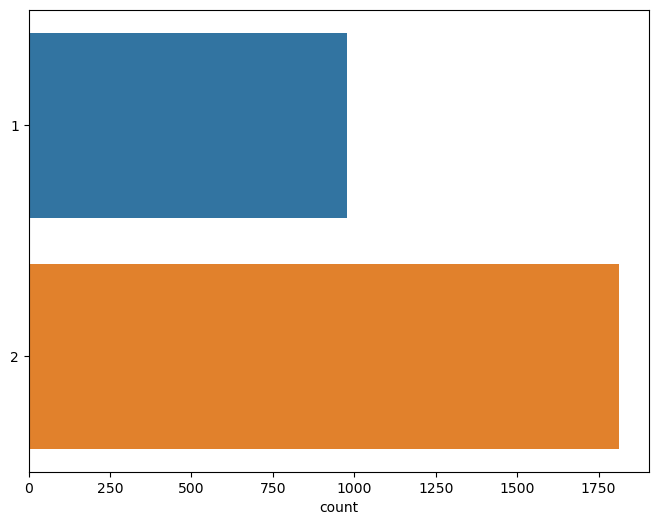

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.countplot(y=y_test_pred_class_3, order=np.unique(y_test_pred_class_3))
plt.show()

In [7]:
import numpy as np
from collections import Counter

lists = np.array([y_test_pred_class_1, y_test_pred_class_2, y_test_pred_class_3])

result = []

for i in range(lists.shape[1]):
    values_at_index = lists[:, i]
    
    counter = Counter(values_at_index)
    most_common = counter.most_common()
    
    max_count = most_common[0][1]
    candidates = [val for val, count in most_common if count == max_count]
    
    if len(candidates) > 1:
        result.append(y_test_pred_class_2[i])
    else:
        result.append(candidates[0])

submission_df = submission_df.assign(target = result)
submission_df.to_csv("result.csv", index=False)

In [8]:
import numpy as np

array1 = np.array(y_test_pred_1)

array2 = np.array(y_test_pred_2)

array3 = np.array(y_test_pred_3)

result_before = array1 + array2 + array3

y_test_pred_class_3 = np.argmax(result_before, axis = 1)
submission_df = submission_df.assign(target = result)
submission_df.to_csv("result_pro.csv", index=False)